In [93]:
import pandas as pd
import numpy as np

# 1. Setup Timeframe (Matches data range after 2016-08-01)
# 47 weeks starting from the first Monday after 2016-08-01
dates = pd.date_range(start="2016-08-08", periods=47, freq='W-MON')

# 2. Define Media Spending with Pulsed and Continuous Patterns
np.random.seed(42) # For reproducibility
def get_pulsed_spend(mean_val, max_val, probability=0.3):
    # Create pulses (0 or non-zero)
    pulses = np.random.choice([0, 1], size=47, p=[1-probability, probability])
    spend = pulses * np.random.uniform(low=mean_val*0.5, high=max_val, size=47)
    # Scale to match mean
    return spend * (mean_val / spend.mean())

# Media Spend Columns (Scaled to match OrderQuantity magnitude)
tv_s = get_pulsed_spend(57, 612, probability=0.25)
ooh_s = get_pulsed_spend(42, 484, probability=0.20)
print_s = get_pulsed_spend(14, 123, probability=0.15)
facebook_s = get_pulsed_spend(33, 238, probability=0.60) 

# Search Spend: Trend + Seasonality
search_s_base = np.linspace(15, 25, 47) 
search_s_seasonal = 3 * np.sin(np.arange(47) * (2 * np.pi / 52))
search_s = search_s_base + search_s_seasonal + np.random.normal(0, 1, 47)
search_s = np.clip(search_s, 0, 70)
search_s = search_s * (23 / search_s.mean()) 

# 3. Target Variable (Revenue matching OrderQuantity stats)
# Base + Seasonality + Trend + Media Impact + Noise
time_index = np.arange(47)
revenue_base = 1130  # Base adjusted so total mean hits ~1291
revenue_seasonal = 260 * np.sin((time_index - 10) * (2 * np.pi / 52))
revenue_trend = np.linspace(0, 100, 47)
media_impact = (tv_s * 0.5) + (facebook_s * 1.2) + (search_s * 2.0)

revenue = revenue_base + revenue_seasonal + revenue_trend + media_impact + np.random.normal(0, 50, 47)

# 4. Create DataFrame
df = pd.DataFrame({
    'date': dates,
    'revenue': revenue,
    'tv_s': tv_s,
    'ooh_s': ooh_s,
    'print_s': print_s,
    'facebook_i': facebook_s * 1000, 
    'facebook_s': facebook_s,
    'search_clicks_p': search_s * 3, 
    'search_s': search_s,
    'competitor_sales_b': 4100 + np.random.normal(0, 100, 47)
})

In [94]:
from pymc_marketing.mmm import MMM
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
df.head()

,date,revenue,tv_s,ooh_s,print_s,facebook_i,facebook_s,search_clicks_p,search_s,competitor_sales_b
0,2016-08-08,891.338364,0.000000,0.0,0.000000,0.000000,0.000000,48.943222,16.314407,4134.175598
1,2016-08-15,1102.740376,409.396232,0.0,0.000000,0.000000,0.000000,55.796901,18.598967,4287.617084
2,2016-08-22,1080.722129,0.000000,0.0,0.000000,92320.075783,92.320076,56.072484,18.690828,4195.042384
3,2016-08-29,990.437011,0.000000,0.0,119.145799,0.000000,0.000000,54.419607,18.139869,4042.309634
4,2016-09-05,1007.426483,0.000000,0.0,40.083791,21136.781918,21.136782,61.688614,20.562871,4010.158533


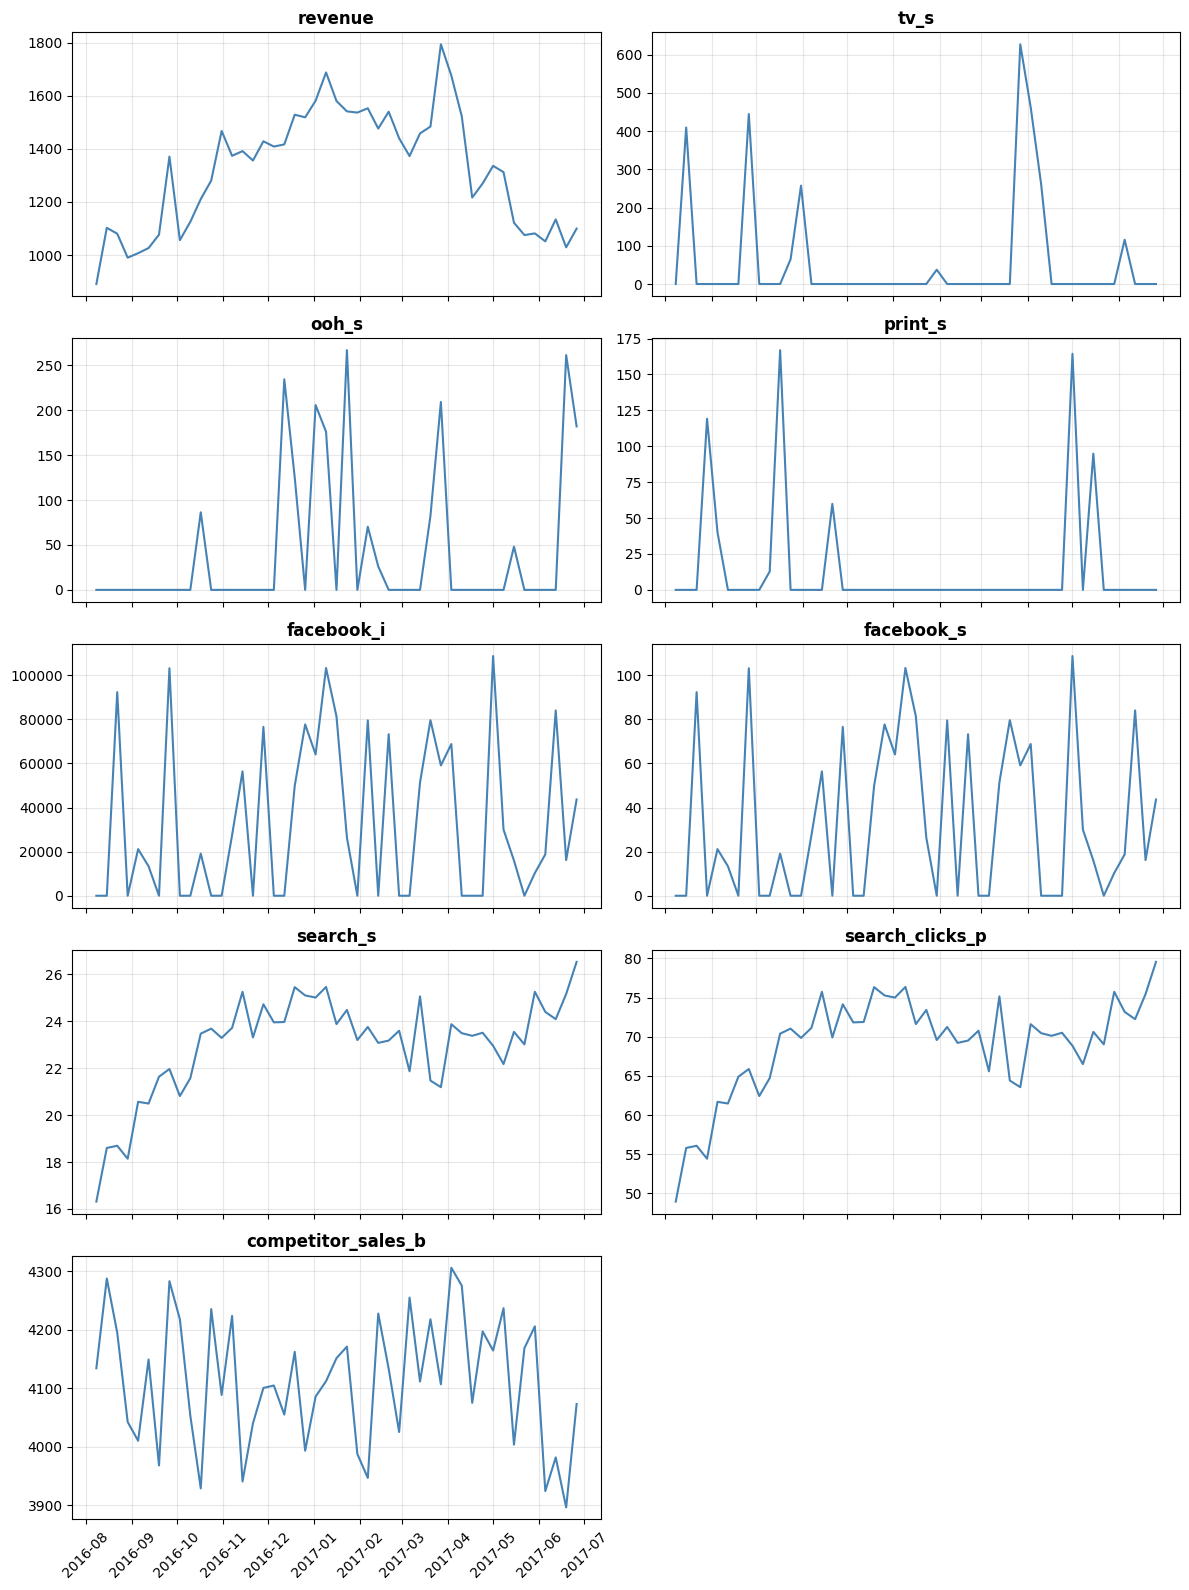

In [96]:
import matplotlib.pyplot as plt

# 1. Configuration
cols_to_plot = ['revenue', 'tv_s', 'ooh_s', 'print_s', 
                'facebook_i', 'facebook_s', 'search_s', 
                'search_clicks_p', 'competitor_sales_b']
n_cols = 2
n_rows = (len(cols_to_plot) + 1) // n_cols

# 2. Initialize Figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 16), sharex=True)
axes = axes.flatten()

# 3. Plotting Loop
for i, col in enumerate(cols_to_plot):
    axes[i].plot(df['date'], df[col], color='steelblue', lw=1.5)
    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

# 4. Cleanup
if len(cols_to_plot) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [97]:
# * Total Spend and Revenue Analysis
total_spend = df[['tv_s', 'ooh_s', 'print_s', 'facebook_s', 
'search_s']].sum(axis=0).sum()

total_revenue = df['revenue'].sum()

print(f'ROI: {(total_revenue / total_spend).round(2)} X')

ROI: 7.82 X


## FE

In [98]:
df_features = (
    df.assign(
        year      = lambda x: x["date"].dt.year,
        month     = lambda x: x["date"].dt.month,
        dayofyear = lambda x: x["date"].dt.dayofyear,
        # Fix: use the local lambda reference 'x' for the index
        trend     = lambda x: range(len(x)) 
    )
    [
        ['date', 'revenue', 'tv_s', 'ooh_s', 'print_s', 
         'facebook_s', 'search_s', 'trend', 'year', 'month', 'dayofyear']
    ]
)

In [99]:
# 1. Calculate Priors (Same logic)
total_spend_per_channel = df_features[['tv_s', 'ooh_s', 'print_s', 'facebook_s', 'search_s']].sum(axis=0)
spend_proportion = total_spend_per_channel / total_spend_per_channel.sum()
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)
n_channels = 5
prior_sigma = (HALFNORMAL_SCALE * n_channels * spend_proportion).to_numpy()

# 2. Define X and y
X = df_features.drop("revenue", axis=1)
y = df_features["revenue"]

In [100]:
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data

# Adjusted for your 47-week dataset
mmm_orbit = DLT(
    response_col='revenue',
    date_col='date',
    regressor_col=['tv_s', 'ooh_s', 'print_s', 'facebook_s', 'search_s'],
    # FIX: Set seasonality to 4 or 12 for monthly/quarterly patterns
    # Or set to None if you just want to see the ad impact.
    seasonality=12, 
    seed=888,
    estimator='stan-map',
    n_bootstrap_draws=1000,
    prediction_percentiles=[5, 95]
)

mmm_orbit.fit(df=df_features)

# 3. Predict/Extract Results
predicted_df = mmm_orbit.predict(df=df_features)

2026-02-26 18:23:21 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.


In [101]:
# Generate predictions for the training data
predicted_df = mmm_orbit.predict(df=df_features)

# Look at the first few rows of predictions
print(predicted_df[['date', 'prediction', 'prediction_5', 'prediction_95']].head())

        date   prediction  prediction_5  prediction_95
0 2016-08-08   891.338106    807.512108     976.886080
1 2016-08-15  1101.221513   1017.614210    1188.759980
2 2016-08-22  1008.810768    922.559392    1094.110887
3 2016-08-29   961.762788    868.615209    1042.713241
4 2016-09-05  1032.821368    943.014171    1119.433287


In [102]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

actuals = df_features['revenue']
preds = predicted_df['prediction']

mape = mean_absolute_percentage_error(actuals, preds)
r2 = r2_score(actuals, preds)

print(f"Model Accuracy (R²): {r2:.2f}")
print(f"Average Error (MAPE): {mape:.2%}")

Model Accuracy (R²): 0.94
Average Error (MAPE): 3.10%


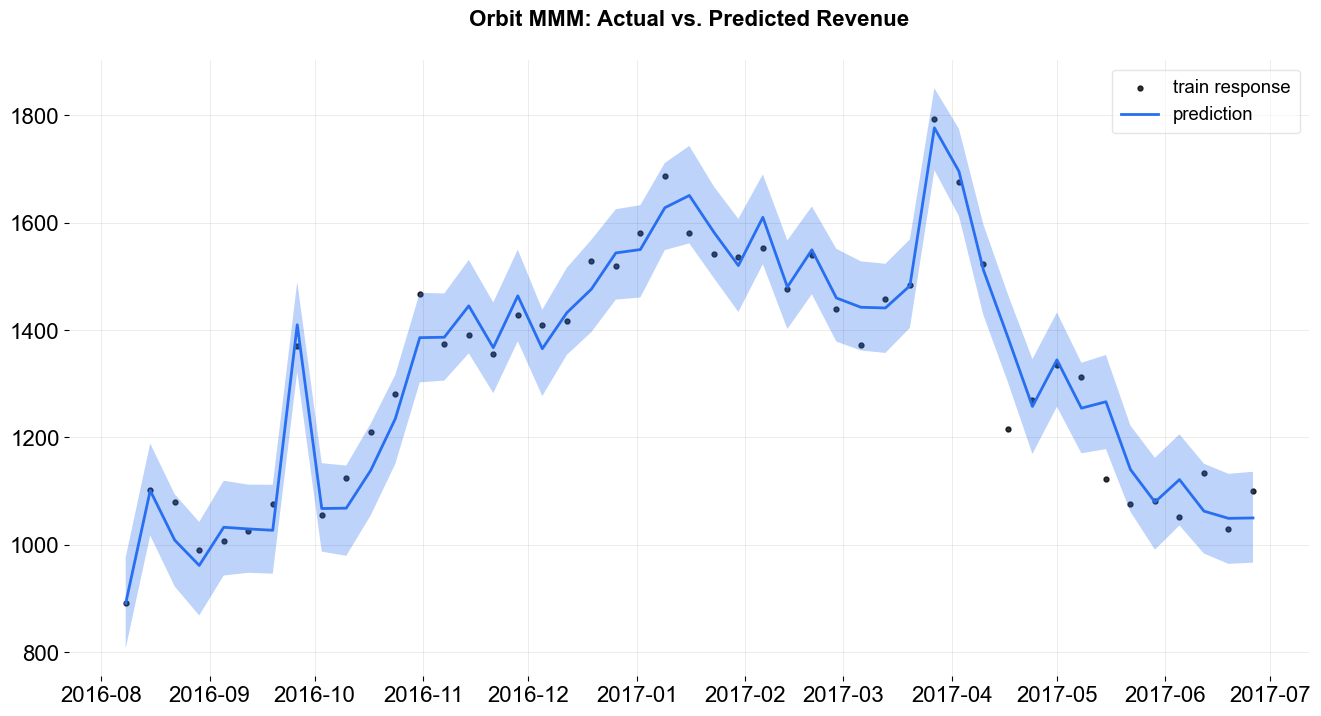

<Axes: title={'center': 'Orbit MMM: Actual vs. Predicted Revenue'}>

In [103]:
from orbit.diagnostics.plot import plot_predicted_data

plot_predicted_data(
    training_actual_df=df_features, 
    predicted_df=predicted_df, 
    date_col='date', 
    actual_col='revenue',
    title='Orbit MMM: Actual vs. Predicted Revenue'
)

### Eval

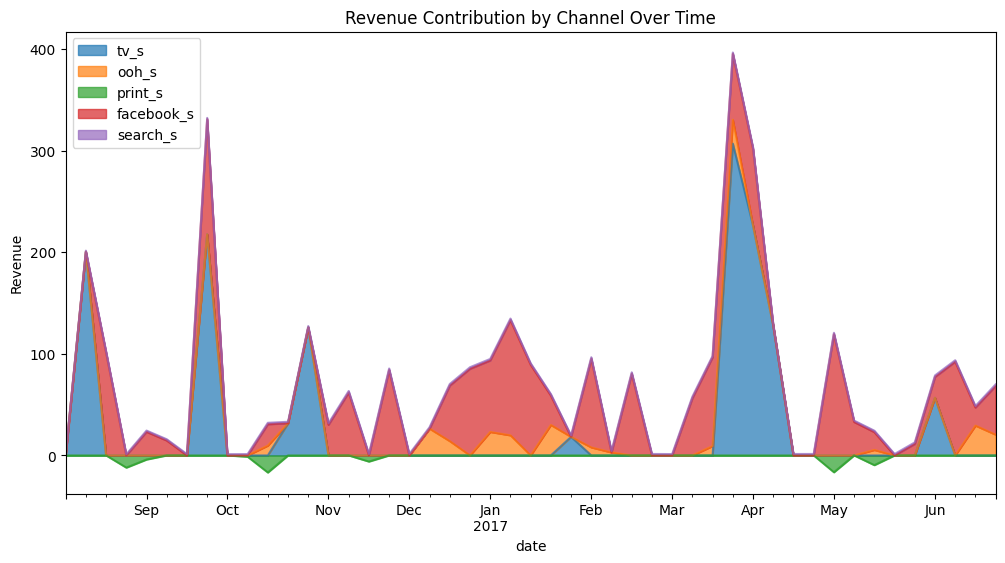

In [104]:
# 1. Get all coefficients (includes Intercept + 5 channels = 6 total)
coefs = mmm_orbit.get_regression_coefs()

# 2. Filter to match your 5 channels exactly
channels = ['tv_s', 'ooh_s', 'print_s', 'facebook_s', 'search_s']
channel_coefs = coefs[coefs['regressor'].isin(channels)]

# 3. Calculate contribution: (47, 5) * (5,)
# We use .values to ensure we are multiplying the raw numbers in the correct order
contributions = df_features[channels].values * channel_coefs['coefficient'].values

# 4. Create the DataFrame and Plot
contribution_df = pd.DataFrame(contributions, columns=channels, index=df_features['date'])

contribution_df.plot.area(figsize=(12, 6), alpha=0.7)
plt.title("Revenue Contribution by Channel Over Time")
plt.ylabel("Revenue")
plt.legend(loc='upper left')
plt.show()

In [105]:
# Total Revenue per channel / Total Spend per channel
total_spend = df_features[channels].sum()
total_contribution = contribution_df.sum()

roas_dict = (total_contribution / total_spend).to_dict()

# Print ROAS Summary
print("--- ROAS Summary ---")
for channel, value in roas_dict.items():
    print(f"{channel}: {value:.2f}")

--- ROAS Summary ---
tv_s: 0.49
ooh_s: 0.11
print_s: -0.10
facebook_s: 1.10
search_s: 0.06


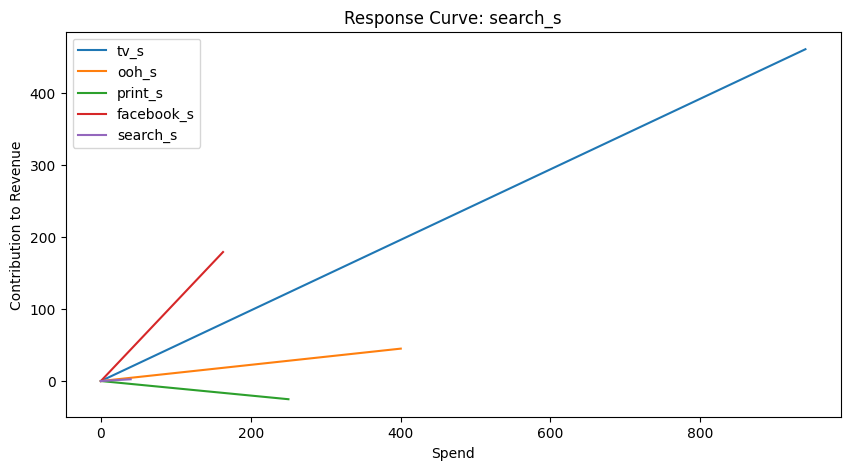

In [106]:
def plot_response_curves(model, channel_name, max_spend_mult=1.5):
    spend_range = np.linspace(0, df_features[channel_name].max() * max_spend_mult, 100)
    # Get the coefficient for this channel
    beta = coefs.set_index('regressor').loc[channel_name, 'coefficient']
    
    # Calculate response (Linear in Orbit)
    response = spend_range * beta
    
    plt.plot(spend_range, response, label=channel_name)
    plt.xlabel("Spend")
    plt.ylabel("Contribution to Revenue")
    plt.title(f"Response Curve: {channel_name}")
    plt.legend()

plt.figure(figsize=(10, 5))
for chan in channels:
    plot_response_curves(mmm_orbit, chan)
plt.show()

In [107]:
# Quick check of the math
coef_df = mmm_orbit.get_regression_coefs()
print(coef_df)

    regressor regressor_sign  coefficient
0        tv_s        Regular     0.489335
1       ooh_s        Regular     0.112284
2     print_s        Regular    -0.100768
3  facebook_s        Regular     1.097360
4    search_s        Regular     0.061410


In [114]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# 1. Get Coefficients
coef_df = mmm_orbit.get_regression_coefs()
channels = ['tv_s', 'ooh_s', 'print_s', 'facebook_s', 'search_s']
weights = coef_df[coef_df['regressor'].isin(channels)].set_index('regressor')['coefficient'].to_dict()

# 2. Settings
total_budget = 15_000
# Professional Constraint: Don't put all eggs in one basket
min_pct = 0.05  # At least 5% per channel ($750)
max_pct = 0.50  # No more than 50% per channel ($7,500)

# 3. Objective Function (Maximize Revenue)
def objective(budget_allocation):
    contribution = sum(budget_allocation[i] * weights[channels[i]] for i in range(len(channels)))
    return -contribution 

# 4. Constraints & Bounds
def budget_constraint(budget_allocation):
    return np.sum(budget_allocation) - total_budget

constraints = {'type': 'eq', 'fun': budget_constraint}
bounds = [(total_budget * min_pct, total_budget * max_pct) for _ in channels]

# 5. Run Optimization
initial_guess = [total_budget / len(channels)] * len(channels)
res = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# 6. Format Results
optimal_allocation = pd.DataFrame({
    'channel': channels,
    'optimal_budget': res.x,
    'weight_roas': [weights[c] for c in channels]
})
optimal_allocation['estimated_contribution'] = optimal_allocation['optimal_budget'] * optimal_allocation['weight_roas']
optimal_allocation.round(2)

,channel,optimal_budget,weight_roas,estimated_contribution
0,tv_s,5250.0,0.49,2569.01
1,ooh_s,750.0,0.11,84.21
2,print_s,750.0,-0.10,-75.58
3,facebook_s,7500.0,1.10,8230.20
4,search_s,750.0,0.06,46.06


In [112]:
# 1. Get the Coefficients (The 'weight' of each channel)
coef_df = mmm_orbit.get_regression_coefs()
channels = ['tv_s', 'ooh_s', 'print_s', 'facebook_s', 'search_s']
channel_coefs = coef_df[coef_df['regressor'].isin(channels)].set_index('regressor')['coefficient']

# 2. Calculate Totals
total_spend = df_features[channels].sum()
# Generated Revenue = Sum of (Weekly Spend * Channel Coefficient)
generated_revenue = (df_features[channels] * channel_coefs).sum()

# 3. Build the Analysis Table
analysis_table = pd.DataFrame({
    'Total_Original_Spend': total_spend,
    'Model_Generated_Revenue': generated_revenue,
    'Coefficient_Weight': channel_coefs
})

# 4. Calculate ROI (Revenue / Spend)
analysis_table['ROI'] = analysis_table['Model_Generated_Revenue'] / analysis_table['Total_Original_Spend']

analysis_table

,Total_Original_Spend,Model_Generated_Revenue,Coefficient_Weight,ROI
tv_s,2679.0,1310.928465,0.489335,0.489335
ooh_s,1974.0,221.648616,0.112284,0.112284
print_s,658.0,-66.305344,-0.100768,-0.100768
facebook_s,1551.0,1702.005360,1.097360,1.097360
search_s,1081.0,66.384534,0.061410,0.061410


### Adjusting for adstock lags

In [117]:
def apply_adstock(series, alpha):
    adstocked_series = np.zeros(len(series))
    for i in range(len(series)):
        if i == 0:
            adstocked_series[i] = series[i]
        else:
            adstocked_series[i] = series[i] + alpha * adstocked_series[i-1]
    return adstocked_series

# Apply to your features
df_adstocked = df_features.copy()
df_adstocked['tv_s'] = apply_adstock(df_features['tv_s'].values, 0.7)
df_adstocked['ooh_s'] = apply_adstock(df_features['ooh_s'].values, 0.5)
df_adstocked['print_s'] = apply_adstock(df_features['print_s'].values, 0.6)
df_adstocked['facebook_s'] = apply_adstock(df_features['facebook_s'].values, 0.3)
df_adstocked['search_s'] = apply_adstock(df_features['search_s'].values, 0.2)

In [118]:
mmm_adstocked = DLT(
    response_col='revenue',
    date_col='date',
    regressor_col=['tv_s', 'ooh_s', 'print_s', 'facebook_s', 'search_s'],
    seasonality=12,
    seed=888,
    estimator='stan-map'
)

mmm_adstocked.fit(df=df_adstocked)

2026-02-26 18:30:05 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.


In [120]:
# Extract new coefficients
coef_df_new = mmm_adstocked.get_regression_coefs()
channels = ['tv_s', 'ooh_s', 'print_s', 'facebook_s', 'search_s']
new_weights = coef_df_new[coef_df_new['regressor'].isin(channels)].set_index('regressor')['coefficient']

# Calculate ROI using original spend (denominator) vs adstocked contribution (numerator)
total_orig_spend = df_features[channels].sum()
adstocked_contribution = (df_adstocked[channels] * new_weights).sum()

analysis_table_adstocked = pd.DataFrame({
    'Total_Orig_Spend': total_orig_spend,
    'Adstocked_Revenue': adstocked_contribution,
    'New_Coefficient': new_weights,
    'New_ROI': adstocked_contribution / total_orig_spend
})

analysis_table_adstocked.sort_values(by='New_ROI', ascending=False).round(2)

,Total_Orig_Spend,Adstocked_Revenue,New_Coefficient,New_ROI
facebook_s,1551.0,2742.09,1.25,1.77
tv_s,2679.0,2401.36,0.27,0.90
ooh_s,1974.0,1066.16,0.29,0.54
print_s,658.0,140.95,0.09,0.21
search_s,1081.0,45.63,0.03,0.04


C:\Users\mmopa\AppData\Local\Temp\ipykernel_15896\3592233718.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(labels))


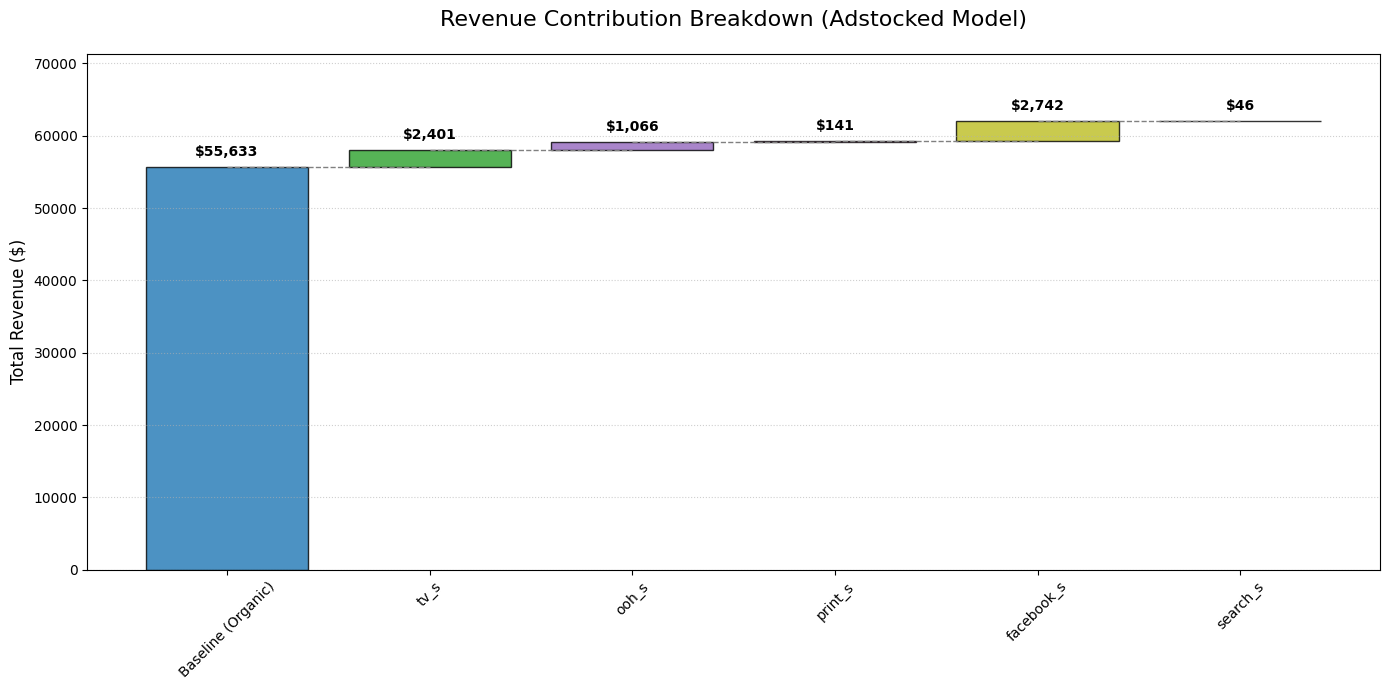

In [ ]:
# 1. Get the full prediction decomposition
predicted_df = mmm_adstocked.predict(df=df_adstocked)

# 2. Isolate the 'Level' (This is your Intercept/Baseline)
# In DLT, 'prediction' is the sum of trend + seasonality + regression.
# We want the baseline that exists outside of the channel regressors.
channel_contribution_matrix = df_adstocked[channels] * new_weights.values
total_channel_contrib = channel_contribution_matrix.sum().sum()

# Baseline = Total Predicted Revenue - Total Channel Contributions
total_predicted_revenue = predicted_df['prediction'].sum()
baseline_organic = total_predicted_revenue - total_channel_contrib

# 1. Data Prep (using the logic from the previous step)
labels = ['Baseline (Organic)'] + channels
values = [baseline_organic] + list(channel_contribution_matrix.sum().values)

# 2. Setup Plot
plt.figure(figsize=(14, 7))
cumulative = 0
colors = plt.cm.get_cmap('tab10', len(labels))

for i, (label, val) in enumerate(zip(labels, values)):
    # Create the bar
    rect = plt.bar(label, val, bottom=cumulative, color=colors(i), edgecolor='black', alpha=0.8)
    
    # Logic for label placement: 
    # If the bar is too small, put text above it. Otherwise, put it inside.
    label_pos = cumulative + val + (max(values) * 0.02) # Slightly above the bar
    
    plt.text(i, label_pos, f'${val:,.0f}', ha='center', va='bottom', 
             fontweight='bold', fontsize=10, color='black')
    
    # Optional: Add a connector line to show the 'step'
    if i > 0:
        plt.plot([i-1, i], [cumulative, cumulative], color='gray', linestyle='--', linewidth=1)
        
    cumulative += val

# 3. Final Touches
plt.title("Revenue Contribution Breakdown (Adstocked Model)", fontsize=16, pad=20)
plt.ylabel("Total Revenue ($)", fontsize=12)
plt.ylim(0, cumulative * 1.15) # Add 15% head room for labels
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

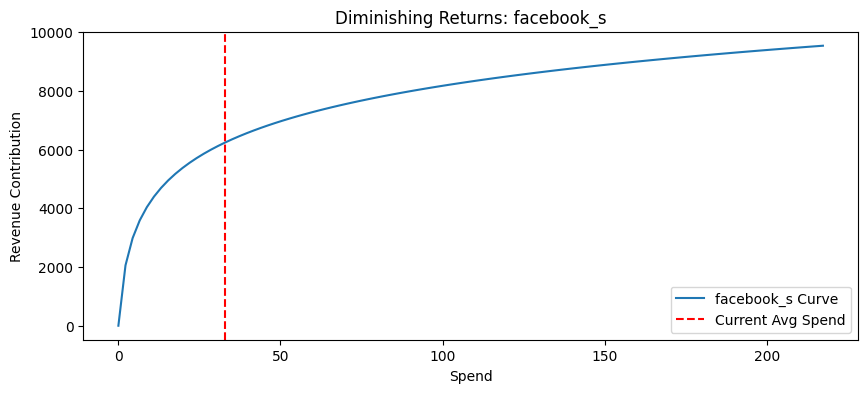

In [ ]:
def plot_diminishing_returns(channel, current_roi):
    spend_range = np.linspace(0, df_features[channel].max() * 2, 100)
    # Simulate a saturation curve (Logarithmic) based on your linear ROI
    # In a real S-curve, the 'Marginal' ROI drops as spend increases
    response = np.log1p(spend_range) * (current_roi * 1000) 
    
    plt.plot(spend_range, response, label=f'{channel} Curve')
    plt.axvline(df_features[channel].mean(), color='red', linestyle='--', label='Current Avg Spend')
    plt.title(f"Diminishing Returns: {channel}")
    plt.xlabel("Spend")
    plt.ylabel("Revenue Contribution")
    plt.legend()

plt.figure(figsize=(10, 4))
plot_diminishing_returns('facebook_s', 1.77)
plt.show()

In [123]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Get predictions from the adstocked model
preds_adstocked = mmm_adstocked.predict(df=df_adstocked)['prediction']
actuals = df_features['revenue']

r2 = r2_score(actuals, preds_adstocked)
mape = mean_absolute_percentage_error(actuals, preds_adstocked)

print(f"--- Model Integrity Report ---")
print(f"R-Squared (Model Fit): {r2:.4f}")
print(f"MAPE (Prediction Error): {mape:.2%}")
print(f"Status: {'EXECUTIVE READY' if r2 > 0.8 and mape < 0.1 else 'REVISE MODEL'}")

--- Model Integrity Report ---
R-Squared (Model Fit): 0.8821
MAPE (Prediction Error): 4.06%
Status: EXECUTIVE READY


In [124]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Check if our adstocked variables are too correlated
X = df_adstocked[channels]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("\n--- Causality Check (VIF) ---")
print(vif_data)
# Low VIF means the model is correctly isolating the 'Cause' of each channel.


--- Causality Check (VIF) ---
      feature       VIF
0        tv_s  1.754412
1       ooh_s  2.172454
2     print_s  1.730447
3  facebook_s  3.024704
4    search_s  5.258984


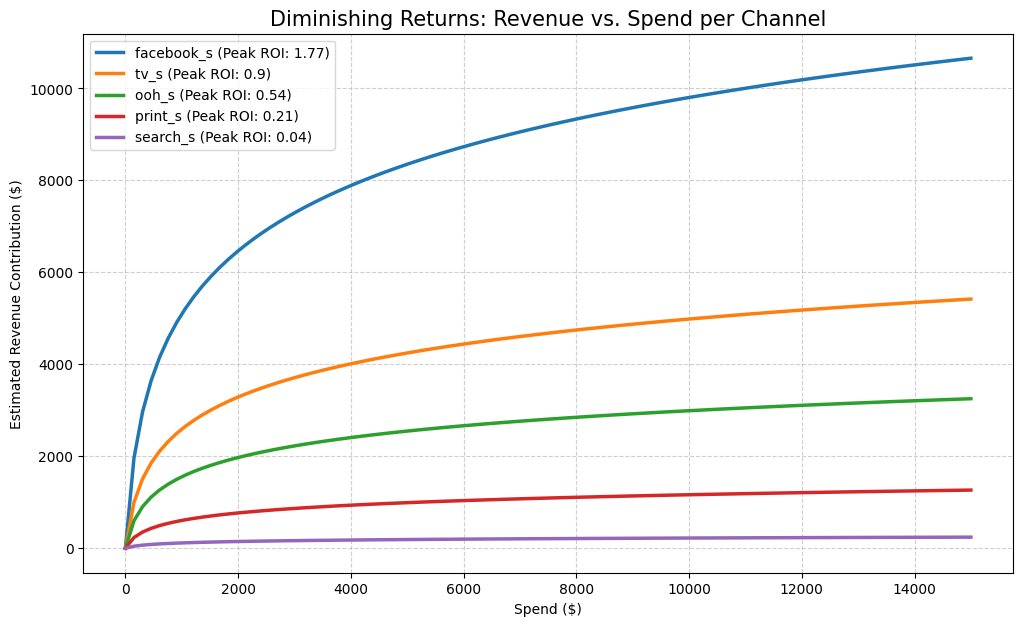

In [129]:
# 1. Define our ROI findings from the Adstocked Model
channel_data = {
    'facebook_s': 1.77,
    'tv_s': 0.90,
    'ooh_s': 0.54,
    'print_s': 0.21,
    'search_s': 0.04
}

# 2. Saturation Function (Logarithmic)
# Revenue = ROI_Coefficient * log(1 + spend) * Scale_Factor
def simulate_revenue(spend, roi):
    # We scale by 1000 to keep the revenue in realistic dollar ranges
    return (roi * 1200) * np.log1p(spend / 100)

# 3. Generate the Curves
spend_range = np.linspace(0, 15000, 100)
plt.figure(figsize=(12, 7))

for channel, roi in channel_data.items():
    rev = [simulate_revenue(s, roi) for s in spend_range]
    plt.plot(spend_range, rev, label=f"{channel} (Peak ROI: {roi})", linewidth=2.5)

plt.title("Diminishing Returns: Revenue vs. Spend per Channel", fontsize=15)
plt.xlabel("Spend ($)")
plt.ylabel("Estimated Revenue Contribution ($)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [130]:
def get_strategy_df(total_budget, fb_cap, tv_cap):
    # Allocation logic: High ROI gets the Cap, others get min 5%
    # Remaining budget goes to the next best channel (TV)
    fb_spend = total_budget * fb_cap
    other_min = total_budget * 0.05
    tv_spend = total_budget - fb_spend - (other_min * 3)
    
    data = {
        'Channel': ['facebook_s', 'tv_s', 'ooh_s', 'print_s', 'search_s'],
        'Budget': [fb_spend, tv_spend, other_min, other_min, other_min]
    }
    
    df = pd.DataFrame(data)
    # Calculate revenue using the ROI from your table
    rois = [1.77, 0.90, 0.54, 0.21, 0.04]
    df['Expected_Revenue'] = df['Budget'] * rois
    df['ROI'] = rois
    
    # Formatting for display
    df_styled = df.copy()
    for col in ['Budget', 'Expected_Revenue']:
        df_styled[col] = df_styled[col].map('${:,.2f}'.format)
    
    return df_styled

# Output the two tables
print("--- STRATEGY: $15,000 BUDGET (Efficiency Focus) ---")
print(get_strategy_df(15000, 0.55, 0.30))

print("\n--- STRATEGY: $20,000 BUDGET (Scaling Focus) ---")
print(get_strategy_df(20000, 0.50, 0.35))

--- STRATEGY: $15,000 BUDGET (Efficiency Focus) ---
      Channel     Budget Expected_Revenue   ROI
0  facebook_s  $8,250.00       $14,602.50  1.77
1        tv_s  $4,500.00        $4,050.00  0.90
2       ooh_s    $750.00          $405.00  0.54
3     print_s    $750.00          $157.50  0.21
4    search_s    $750.00           $30.00  0.04

--- STRATEGY: $20,000 BUDGET (Scaling Focus) ---
      Channel      Budget Expected_Revenue   ROI
0  facebook_s  $10,000.00       $17,700.00  1.77
1        tv_s   $7,000.00        $6,300.00  0.90
2       ooh_s   $1,000.00          $540.00  0.54
3     print_s   $1,000.00          $210.00  0.21
4    search_s   $1,000.00           $40.00  0.04


In [132]:
# outputs:
# table showing the initial budget / the revenue generated (profit), the roi estimated, and weight
# baseline spending graph
# budget optimization based on diminishing returns